# Baymax - Data Preprocessing

### 📋 Notebook Overview

This notebook implements comprehensive data preprocessing for mental health assessment data collected from Bangladeshi university students across three standardized scales:
- **PSS-10** (Perceived Stress Scale) — 10 items measuring stress levels
- **GAD-7** (Generalized Anxiety Disorder) — 7 items measuring anxiety symptoms
- **PHQ-9** (Patient Health Questionnaire) — 9 items measuring depression severity

### 📋 Notebook Structure

This notebook is organized into 4 parts:
- **Part 1:** Imports & Configuration
- **Part 2:** Data Loading & Processing
- **Part 3:** Exploratory Data Analysis
- **Part 4:** Feature Engineering

## Part 1: Imports & Configuration

This cell contains all imports, configurations, and helper functions used throughout the preprocessing.

### What this cell does:

**1. Import Libraries**
- Core: `pandas`, `numpy`, `pathlib`
- Visualization: `matplotlib`, `seaborn`
- Machine Learning: `scikit-learn` (preprocessing, model_selection)
- Statistical Analysis: `scipy`
- Utilities: `joblib` for saving scalers

**2. Global Configuration**
- Set random state for reproducibility (`RANDOM_STATE = 42`)
- Configure pandas display options
- Set plotting styles and figure parameters

**3. Path Configuration**
- Define all input/output directories
- Raw data path
- Processed data path
- Feature output path
- Figure directory

**4. Column Definitions & Mappings**
- Demographic column names
- Mental Health Status levels
- Response mappings for PSS-10, GAD-7, PHQ-9
- Question labels for all three scales

**5. Helper Functions**
- **Data Processing:** `extract_initials()`
- **Mental Health Status Calculation:** `categorize_pss_severity()`, `categorize_gad_severity()`, `categorize_phq_severity()`, `majority_voting()`, `calculate_mental_health_status()`
- **Visualization:** `save_fig()`

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

# Core Libraries
import os
import warnings
import re
from pathlib import Path
warnings.filterwarnings("ignore")

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Utilities
import joblib

# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================

# Random State for Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Pandas Display Options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Plotting Configuration
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 120})

# Figure Settings
FIG_FORMAT = "png"
FIG_DPI = 300

# ============================================================================
# PATH CONFIGURATION
# ============================================================================

# Base Directory
BASE_DIR = Path.cwd().parents[0]

# Data Paths
RAW_PATH = BASE_DIR / "data" / "raw" / "mhp_dataset.csv"

# Processed Data Path
PROCESSED_TABULAR = BASE_DIR / "data" / "processed" / "mhp_processed.csv"

# Feature Output Path
FEATURES_DIR = BASE_DIR / "features"

# Figure Output Path
FIG_DIR = BASE_DIR / "figures" / "Exploratory Data Analysis"

# ============================================================================
# COLUMN DEFINITIONS
# ============================================================================

# Demographic Column Names
DEMOGRAPHIC_COLS = [
    "Age", "Gender", "University", "Department",
    "Year", "CGPA", "Scholarship"
]

# Mental Health Status Levels
MENTAL_HEALTH_LEVELS = ["Stable", "Challenged", "Critical"]

# Severity Level Order
SEVERITY_LEVELS = ["Stable", "Challenged", "Critical"]

# ============================================================================
# MAPPING DICTIONARIES
# ============================================================================

# PSS-10 (Stress) Response Mapping
PSS_MAP = {
    "0 - Never": 0,
    "1 - Almost Never": 1,
    "2 - Sometimes": 2,
    "3 - Fairly Often": 3,
    "4 - Very Often": 4
}

# GAD-7 (Anxiety) Response Mapping
GAD_MAP = {
    "0 - Not at all": 0,
    "1 - Several days (less than 15 days)": 1,
    "1 - Several days": 1,
    "2 - More than half the semester": 2,
    "2 - More than half the days": 2,
    "3 - Nearly every day": 3
}

# PHQ-9 (Depression) Response Mapping
PHQ_MAP = {
    "0 - Not at all": 0,
    "1 - Several days": 1,
    "2 - More than half the days": 2,
    "3 - Nearly every day": 3
}

# ============================================================================
# QUESTION LABELS
# ============================================================================

# PSS-10 Question Labels
PSS_LABELS = {
    "PSS1":  "Emotional Response to Setbacks",
    "PSS2":  "Sense of Control Over Academics",
    "PSS3":  "Overall Academic Stress Level",
    "PSS4":  "Confidence in Coping Abilities",
    "PSS5":  "Problem-Solving Self-Efficacy",
    "PSS6":  "Perception of Academic Progress",
    "PSS7":  "Tolerance for Academic Frustration",
    "PSS8":  "Academic Self-Confidence",
    "PSS9":  "Frustration With Academic Results",
    "PSS10": "Sense of Academic Helplessness"
}

# GAD-7 Question Labels
GAD_LABELS = {
    "GAD1": "Feeling Nervous or On Edge",
    "GAD2": "Uncontrollable Worry",
    "GAD3": "Difficulty Relaxing",
    "GAD4": "Irritability Due to Anxiety",
    "GAD5": "Frequency of Excessive Worry",
    "GAD6": "Physical Symptoms of Anxiety",
    "GAD7": "Fear of Something Bad Happening"
}

# PHQ-9 Question Labels
PHQ_LABELS = {
    "PHQ1": "Loss of Interest",
    "PHQ2": "Low Mood or Hopelessness",
    "PHQ3": "Sleep Difficulties",
    "PHQ4": "Fatigue or Low Energy",
    "PHQ5": "Appetite or Weight Changes",
    "PHQ6": "Feelings of Worthlessness",
    "PHQ7": "Difficulty Concentrating",
    "PHQ8": "Psychomotor Changes",
    "PHQ9": "Suicidal Thoughts"
}

# ============================================================================
# HELPER FUNCTIONS - DATA PROCESSING
# ============================================================================

def extract_initials(text):
    """Extract initials from text (e.g., 'University Name (UN)' -> 'UN')"""
    if isinstance(text, str):
        m = re.search(r"\(([^)]+)\)", text)
        if m:
            return m.group(1).strip()
        else:
            return text.strip().split()[0]
    return text

# ============================================================================
# HELPER FUNCTIONS - MENTAL HEALTH STATUS CALCULATION (CLINICAL THRESHOLDS)
# ============================================================================

def categorize_pss_severity(raw_score):
    """
    Categorize PSS-10 raw score using clinical thresholds.

    Clinical Thresholds:
        0-13  : Low stress      (Stable)
        14-26 : Moderate stress (Challenged)
        27-40 : High stress     (Critical)
    """
    if pd.isna(raw_score):
        return None
    if raw_score <= 13:
        return "Stable"
    elif raw_score <= 26:
        return "Challenged"
    else:
        return "Critical"


def categorize_gad_severity(raw_score):
    """
    Categorize GAD-7 raw score using clinical thresholds.

    Clinical Thresholds:
        0-4   : Minimal anxiety           (Stable)
        5-14  : Mild to moderate anxiety  (Challenged)
        15-21 : Severe anxiety            (Critical)
    """
    if pd.isna(raw_score):
        return None
    if raw_score <= 4:
        return "Stable"
    elif raw_score <= 14:
        return "Challenged"
    else:
        return "Critical"


def categorize_phq_severity(raw_score):
    """
    Categorize PHQ-9 raw score using clinical thresholds.

    Clinical Thresholds:
        0-4   : Minimal depression                     (Stable)
        5-14  : Mild to moderate depression            (Challenged)
        15-27 : Moderately severe to severe depression (Critical)
    """
    if pd.isna(raw_score):
        return None
    if raw_score <= 4:
        return "Stable"
    elif raw_score <= 14:
        return "Challenged"
    else:
        return "Critical"


def majority_voting(stress_level, anxiety_level, depression_level):
    """
    Apply majority voting to determine overall Mental Health Status.

    Logic:
        - Most frequent category wins (2 or 3 votes)
        - If tie (all three different), use depression_level as tiebreaker
    """
    if pd.isna(stress_level) or pd.isna(anxiety_level) or pd.isna(depression_level):
        return None

    votes = [stress_level, anxiety_level, depression_level]
    vote_counts = pd.Series(votes).value_counts()

    if vote_counts.iloc[0] >= 2:
        return vote_counts.index[0]

    return depression_level


def calculate_mental_health_status(pss_raw, gad_raw, phq_raw):
    """
    Complete pipeline to calculate Mental Health Status using clinical thresholds.

    Returns:
        Dictionary with Stress Level, Anxiety Level, Depression Level,
        and Mental Health Status.
    """
    stress_level     = categorize_pss_severity(pss_raw)
    anxiety_level    = categorize_gad_severity(gad_raw)
    depression_level = categorize_phq_severity(phq_raw)

    mental_health_status = majority_voting(stress_level, anxiety_level, depression_level)

    return {
        "Stress Level":         stress_level,
        "Anxiety Level":        anxiety_level,
        "Depression Level":     depression_level,
        "Mental Health Status": mental_health_status
    }

# ============================================================================
# HELPER FUNCTIONS - VISUALIZATION
# ============================================================================

def save_fig(fig, name, fig_dir):
    """Save figure to the specified figures directory."""
    fig_dir.mkdir(parents=True, exist_ok=True)
    path = fig_dir / f"{name}.{FIG_FORMAT}"
    fig.savefig(path, format=FIG_FORMAT, bbox_inches="tight", dpi=FIG_DPI)
    print(f"✅ Figure saved: {path.resolve()}")


print("IMPORTS & CONFIGURATION LOADED SUCCESSFULLY")

IMPORTS & CONFIGURATION LOADED SUCCESSFULLY


## Part 2: Data Loading & Processing

This cell handles the complete data loading and processing, transforming raw survey responses into a clean, structured dataset ready for analysis.

### What this cell does:

**1. Load Raw Data**
- Reads the raw CSV file from `data/raw/mhp_dataset.csv`
- Displays initial dataset shape and structure

**2. Clean Demographic Columns**
- Renames first 7 columns to standard demographic names
- Standardizes Gender values (converts "Prefer not to say" to "Other")
- Extracts university initials from full names
- Simplifies Department and Year fields
- Standardizes Scholarship values (Yes/No)

**3. Process PSS-10 (Stress) Scale**
- Renames columns to PSS1–PSS10
- Maps text responses to numeric values (0–4)
- Validates data types

**4. Process GAD-7 (Anxiety) Scale**
- Renames columns to GAD1–GAD7
- Maps text responses to numeric values (0–3)
- Validates data types

**5. Process PHQ-9 (Depression) Scale**
- Renames columns to PHQ1–PHQ9
- Maps text responses to numeric values (0–3)
- Validates data types

**6. Calculate Raw Scores**
- PSS Raw Score: Sum of PSS1–PSS10 (range: 0–40)
- GAD Raw Score: Sum of GAD1–GAD7 (range: 0–21)
- PHQ Raw Score: Sum of PHQ1–PHQ9 (range: 0–27)

**7. Generate Severity Levels & Mental Health Status**
- Apply clinical thresholds for categorization:
  - PSS-10: 0–13 (Stable), 14–26 (Challenged), 27–40 (Critical)
  - GAD-7: 0–4 (Stable), 5–14 (Challenged), 15–21 (Critical)
  - PHQ-9: 0–4 (Stable), 5–14 (Challenged), 15–27 (Critical)
- Generate individual severity levels (Stress Level, Anxiety Level, Depression Level)
- Apply majority voting logic to determine final Mental Health Status

**8. Reorder Columns**
- Organize columns logically:
  - Demographics (7 columns)
  - PSS items + PSS Raw Score + Stress Level (12 columns)
  - GAD items + GAD Raw Score + Anxiety Level (9 columns)
  - PHQ items + PHQ Raw Score + Depression Level (11 columns)
  - Mental Health Status (1 column)
- Total: 40 columns

**9. Data Quality Checks**
- Handle missing values (numeric: median, categorical: mode)
- Remove duplicate rows
- Verify data integrity

**10. Save Processed Dataset**
- Saves to `data/processed/mhp_processed.csv`
- Verifies successful save operation

In [2]:
# ============================================================================
# LOAD RAW DATA
# ============================================================================

print("=" * 80)
print("PART 2: DATA LOADING & PROCESSING")
print("=" * 80)

df = pd.read_csv(RAW_PATH)
print(f"\n💾 Loaded raw data from: {RAW_PATH}")
print(f"Shape before processing: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# ============================================================================
# STEP 1: DEMOGRAPHIC COLUMNS CLEANUP
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: CLEANING DEMOGRAPHIC COLUMNS")
print("=" * 80)

# Rename first 7 columns to standard demographic names
df.rename(columns=dict(zip(df.columns[:7], DEMOGRAPHIC_COLS)), inplace=True)

# Clean Gender column
df["Gender"] = df["Gender"].replace({
    "Prefer not to say": "Other",
    "prefer not to say": "Other"
}).str.title()

# Extract university initials
df["University"] = df["University"].apply(extract_initials)

# Extract first word from Department
df["Department"] = df["Department"].astype(str).str.split().str[0]

# Extract first word from Year
df["Year"] = df["Year"].astype(str).str.split().str[0]

# Standardize Scholarship values
df["Scholarship"] = df["Scholarship"].replace({
    "Yes, full waiver":    "Yes",
    "Yes, partial waiver": "Yes",
    "No waiver":           "No"
}).fillna("No")

print("\n✅ Demographic columns cleaned:")
print(df[DEMOGRAPHIC_COLS].head())

# ============================================================================
# STEP 2: PSS-10 (STRESS) COLUMNS PROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: PROCESSING PSS-10 (STRESS) SCALE")
print("=" * 80)

# Rename PSS columns
pss_cols = df.columns[7:17]
pss_col_names = [f"PSS{i+1}" for i in range(10)]
df.rename(columns=dict(zip(pss_cols, pss_col_names)), inplace=True)

# Map text responses to numeric values
for c in pss_col_names:
    df[c] = df[c].replace(PSS_MAP)
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(f"\n✅ PSS-10 columns processed: {pss_col_names}")
print("\nSample PSS data:")
print(df[pss_col_names].head())

# ============================================================================
# STEP 3: GAD-7 (ANXIETY) COLUMNS PROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: PROCESSING GAD-7 (ANXIETY) SCALE")
print("=" * 80)

# Rename GAD columns
gad_cols = df.columns[17:24]
gad_col_names = [f"GAD{i+1}" for i in range(7)]
df.rename(columns=dict(zip(gad_cols, gad_col_names)), inplace=True)

# Map text responses to numeric values
for c in gad_col_names:
    df[c] = df[c].replace(GAD_MAP)
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(f"\n✅ GAD-7 columns processed: {gad_col_names}")
print("\nSample GAD data:")
print(df[gad_col_names].head())

# ============================================================================
# STEP 4: PHQ-9 (DEPRESSION) COLUMNS PROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: PROCESSING PHQ-9 (DEPRESSION) SCALE")
print("=" * 80)

# Rename PHQ columns
phq_cols = df.columns[24:33]
phq_col_names = [f"PHQ{i+1}" for i in range(9)]
df.rename(columns=dict(zip(phq_cols, phq_col_names)), inplace=True)

# Map text responses to numeric values
for c in phq_col_names:
    df[c] = df[c].replace(PHQ_MAP)
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(f"\n✅ PHQ-9 columns processed: {phq_col_names}")
print("\nSample PHQ data:")
print(df[phq_col_names].head())

# ============================================================================
# STEP 5: CALCULATE RAW SCORES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: CALCULATING RAW SCORES")
print("=" * 80)

df["PSS Raw Score"] = df[pss_col_names].sum(axis=1)
print(f"\n✅ PSS Raw Score calculated (range: 0-40)")
print(f"   Min: {df['PSS Raw Score'].min()}, Max: {df['PSS Raw Score'].max()}, Mean: {df['PSS Raw Score'].mean():.2f}")

df["GAD Raw Score"] = df[gad_col_names].sum(axis=1)
print(f"\n✅ GAD Raw Score calculated (range: 0-21)")
print(f"   Min: {df['GAD Raw Score'].min()}, Max: {df['GAD Raw Score'].max()}, Mean: {df['GAD Raw Score'].mean():.2f}")

df["PHQ Raw Score"] = df[phq_col_names].sum(axis=1)
print(f"\n✅ PHQ Raw Score calculated (range: 0-27)")
print(f"   Min: {df['PHQ Raw Score'].min()}, Max: {df['PHQ Raw Score'].max()}, Mean: {df['PHQ Raw Score'].mean():.2f}")

print("\nSample raw scores:")
print(df[["PSS Raw Score", "GAD Raw Score", "PHQ Raw Score"]].head(10))

# ============================================================================
# STEP 6: GENERATE SEVERITY LEVELS & MENTAL HEALTH STATUS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: GENERATING SEVERITY LEVELS & MENTAL HEALTH STATUS")
print("=" * 80)

results = df.apply(
    lambda row: calculate_mental_health_status(
        row["PSS Raw Score"],
        row["GAD Raw Score"],
        row["PHQ Raw Score"]
    ),
    axis=1
)

df["Stress Level"]         = results.apply(lambda x: x["Stress Level"])
df["Anxiety Level"]        = results.apply(lambda x: x["Anxiety Level"])
df["Depression Level"]     = results.apply(lambda x: x["Depression Level"])
df["Mental Health Status"] = results.apply(lambda x: x["Mental Health Status"])

print("\n✅ Severity levels and Mental Health Status generated")

print("\n💾 Stress Level distribution:")
print(df["Stress Level"].value_counts().sort_index())

print("\n💾 Anxiety Level distribution:")
print(df["Anxiety Level"].value_counts().sort_index())

print("\n💾 Depression Level distribution:")
print(df["Depression Level"].value_counts().sort_index())

print("\n💾 Mental Health Status distribution:")
print(df["Mental Health Status"].value_counts().sort_index())

print("\nSample of generated columns:")
display_cols = ["PSS Raw Score", "Stress Level", "GAD Raw Score", "Anxiety Level",
                "PHQ Raw Score", "Depression Level", "Mental Health Status"]
print(df[display_cols].head(10))

# ============================================================================
# STEP 7: REORDER COLUMNS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: REORDERING COLUMNS")
print("=" * 80)

new_column_order = []
new_column_order.extend(DEMOGRAPHIC_COLS)
new_column_order.extend(pss_col_names)
new_column_order.append("PSS Raw Score")
new_column_order.append("Stress Level")
new_column_order.extend(gad_col_names)
new_column_order.append("GAD Raw Score")
new_column_order.append("Anxiety Level")
new_column_order.extend(phq_col_names)
new_column_order.append("PHQ Raw Score")
new_column_order.append("Depression Level")
new_column_order.append("Mental Health Status")

df = df[new_column_order]

print("\n✅ Columns reordered successfully")
print(f"\n💾 New column structure ({len(df.columns)} columns):")

print("\n1. Demographics (7):")
for i, col in enumerate(DEMOGRAPHIC_COLS, 1):
    print(f"   {i}. {col}")

print(f"\n2. PSS-10 + Raw Score + Stress Level ({len(pss_col_names) + 2}):")
for i, col in enumerate(pss_col_names + ["PSS Raw Score", "Stress Level"], 1):
    print(f"   {i}. {col}")

print(f"\n3. GAD-7 + Raw Score + Anxiety Level ({len(gad_col_names) + 2}):")
for i, col in enumerate(gad_col_names + ["GAD Raw Score", "Anxiety Level"], 1):
    print(f"   {i}. {col}")

print(f"\n4. PHQ-9 + Raw Score + Depression Level ({len(phq_col_names) + 2}):")
for i, col in enumerate(phq_col_names + ["PHQ Raw Score", "Depression Level"], 1):
    print(f"   {i}. {col}")

print(f"\n5. Mental Health Status (1):")
print(f"   1. Mental Health Status")

print("\nSample of reordered data:")
print(df.head())

# ============================================================================
# STEP 8: VERIFY COMPOSITE LOGIC
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8: VERIFYING COMPOSITE LOGIC")
print("=" * 80)

print("\n💾 Sample cases for each Mental Health Status:")
for status in MENTAL_HEALTH_LEVELS:
    print(f"\n{status.upper()}:")
    sample = df[df["Mental Health Status"] == status].head(3)
    if len(sample) > 0:
        for idx, row in sample.iterrows():
            print(f"   Case {idx}:")
            print(f"     Stress: {row['Stress Level']}, Anxiety: {row['Anxiety Level']}, Depression: {row['Depression Level']}")
            print(f"     → Result: {row['Mental Health Status']}")
    else:
        print("   No cases found")

# ============================================================================
# STEP 9: DATA QUALITY CHECKS - MISSING VALUES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9: DATA QUALITY CHECKS - MISSING VALUES")
print("=" * 80)

print("\nDataset info before cleaning:")
print(df.info())

missing_counts = df.isna().sum()
missing_total  = missing_counts.sum()

print("\nMissing values summary:")
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

if missing_total > 0:
    print(f"\n💾 Found {missing_total} missing values. Handling them now...")

    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = df.select_dtypes(include=["object"]).columns

    df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.median()))
    df[cat_cols] = df[cat_cols].apply(
        lambda col: col.fillna(col.mode()[0] if not col.mode().empty else "Unknown")
    )

    print("✅ Missing values handled:")
    print("   - Numeric columns    → filled with median")
    print("   - Categorical columns → filled with mode")
else:
    print("\n✅ No missing values found.")

# ============================================================================
# STEP 10: DATA QUALITY CHECKS - DUPLICATE ROWS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10: DATA QUALITY CHECKS - DUPLICATE ROWS")
print("=" * 80)

dup_count = df.duplicated().sum()
print(f"\nDuplicate rows found: {dup_count}")

if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"✅ Removed {dup_count} duplicate rows.")
else:
    print("✅ No duplicate rows found.")

# ============================================================================
# STEP 11: FINAL DATASET STRUCTURE
# ============================================================================

print("\n" + "=" * 80)
print("STEP 11: FINAL DATASET STRUCTURE")
print("=" * 80)

print(f"\n💾 Final dataset shape: {df.shape}")
print(f"\n💾 Column categories:")
print(f"   - Demographics:    {len(DEMOGRAPHIC_COLS)} columns")
print(f"   - PSS (Stress):    {len(pss_col_names)} items + PSS Raw Score + Stress Level")
print(f"   - GAD (Anxiety):   {len(gad_col_names)} items + GAD Raw Score + Anxiety Level")
print(f"   - PHQ (Depression): {len(phq_col_names)} items + PHQ Raw Score + Depression Level")
print(f"   - Target:          Mental Health Status")
print(f"\n   Total columns: {len(df.columns)}")

print("\n💾 All columns in order:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

# ============================================================================
# STEP 12: SAVE PROCESSED DATASET
# ============================================================================

print("\n" + "=" * 80)
print("STEP 12: SAVING PROCESSED DATASET")
print("=" * 80)

PROCESSED_TABULAR.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(PROCESSED_TABULAR, index=False)

print(f"\n✅ Processed dataset saved to:")
print(f"   {PROCESSED_TABULAR.resolve()}")
print(f"\nFile size: {PROCESSED_TABULAR.stat().st_size / 1024:.2f} KB")

df_verify = pd.read_csv(PROCESSED_TABULAR)
print(f"Verification - Loaded shape:    {df_verify.shape}")
print(f"Verification - Missing values:  {df_verify.isna().sum().sum()}")

PART 2: DATA LOADING & PROCESSING

💾 Loaded raw data from: d:\Programming\Projects\Baymax\data\raw\mhp_dataset.csv
Shape before processing: (2028, 33)

First few rows:
  1. Age 2. Gender                                        3. University  \
0  18-22    Female             Independent University, Bangladesh (IUB)   
1  18-22      Male             Independent University, Bangladesh (IUB)   
2  18-22      Male  American International University Bangladesh (AIUB)   
3  18-22      Male  American International University Bangladesh (AIUB)   
4  18-22      Male                         North South University (NSU)   

                                  4. Department           5. Academic Year  \
0  Engineering - CS / CSE / CSC / Similar to CS  Second Year or Equivalent   
1  Engineering - CS / CSE / CSC / Similar to CS   Third Year or Equivalent   
2  Engineering - CS / CSE / CSC / Similar to CS   Third Year or Equivalent   
3  Engineering - CS / CSE / CSC / Similar to CS   Third Year or Equiv

## Part 3: Exploratory Data Analysis

This cell performs exploratory data analysis to understand patterns, distributions, and relationships in the mental health assessment data.

### What this cell does:

**1. Load Processed Dataset**
- Loads the cleaned dataset from Part 2
- Automatically detects PSS, GAD, and PHQ columns
- Creates output directory for visualizations

**2. Generate 7 Visualizations**

**Mental Health Status Analysis:**
- **Visualization 1:** Mental Health Status distribution bar chart

**Severity Level Analysis:**
- **Visualization 2:** Individual severity levels (Stress / Anxiety / Depression) side-by-side bar charts

**Correlation Analysis:**
- **Visualization 3:** Correlation among raw scores (PSS, GAD, PHQ) — heatmap
- **Visualization 4:** Combined correlation heatmap (all 26 items) with section dividers

**Response Distribution Analysis:**
- **Visualization 5:** PSS-10 response distribution (stacked horizontal bars)
- **Visualization 6:** GAD-7 response distribution (stacked horizontal bars)
- **Visualization 7:** PHQ-9 response distribution (stacked horizontal bars)

**3. Save All Figures**
- All visualizations saved to `figures/Exploratory Data Analysis/`
- High resolution PNG format (300 DPI)
- Professional styling with seaborn

PART 3: EXPLORATORY DATA ANALYSIS

💾 Loaded processed dataset from: d:\Programming\Projects\Baymax\data\processed\mhp_processed.csv
Shape: (2022, 40)

✅ Detected scale columns:
   PSS (Stress):    10 items
   GAD (Anxiety):   7 items
   PHQ (Depression): 9 items
   Total:           26 items

💾 Figures will be saved to: d:\Programming\Projects\Baymax\figures\Exploratory Data Analysis

VISUALIZATION 1: MENTAL HEALTH STATUS DISTRIBUTION
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\01_mental_health_status_distribution.png


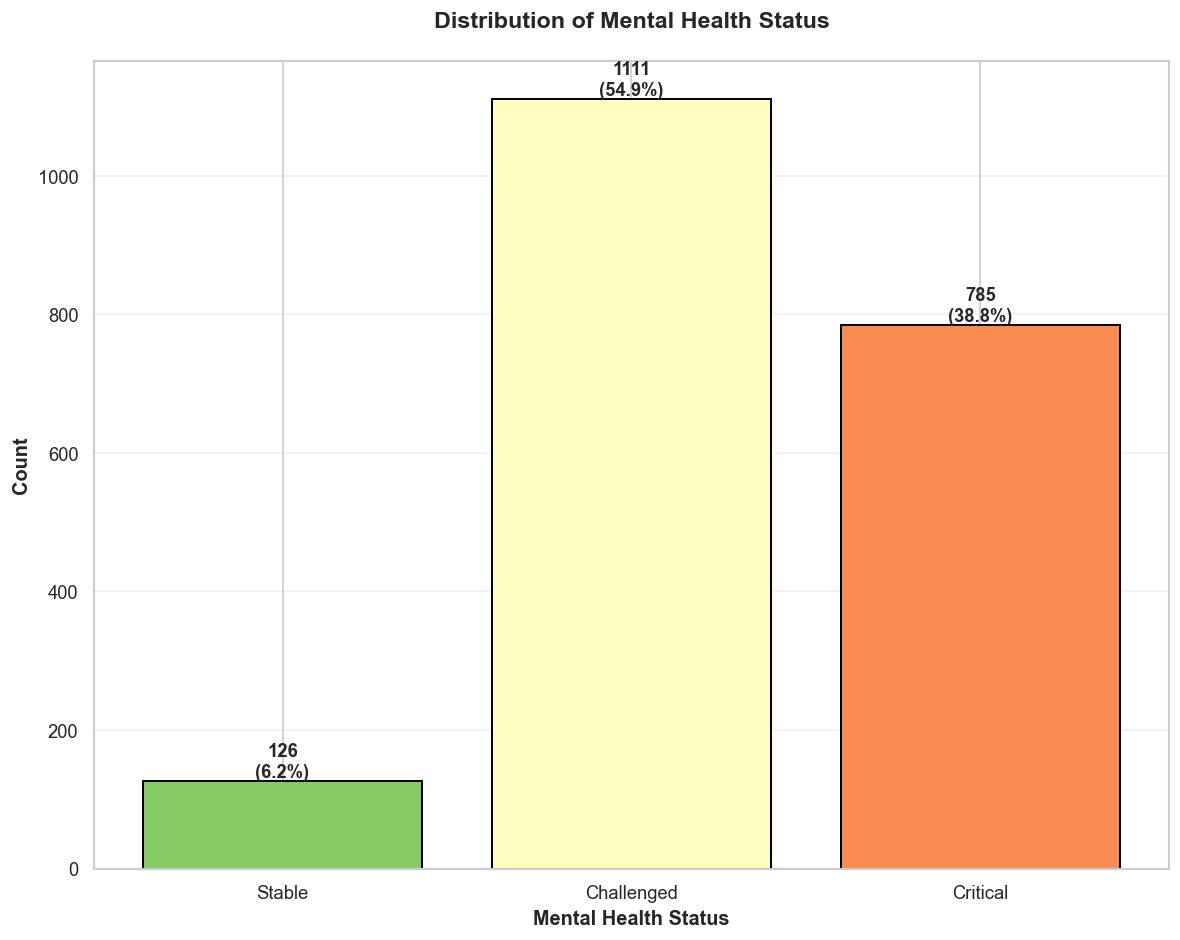


✅ Mental Health Status distribution chart created
   Distribution: {'Stable': 126, 'Challenged': 1111, 'Critical': 785}

VISUALIZATION 2: INDIVIDUAL SEVERITY LEVELS DISTRIBUTION
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\02_individual_severity_levels.png


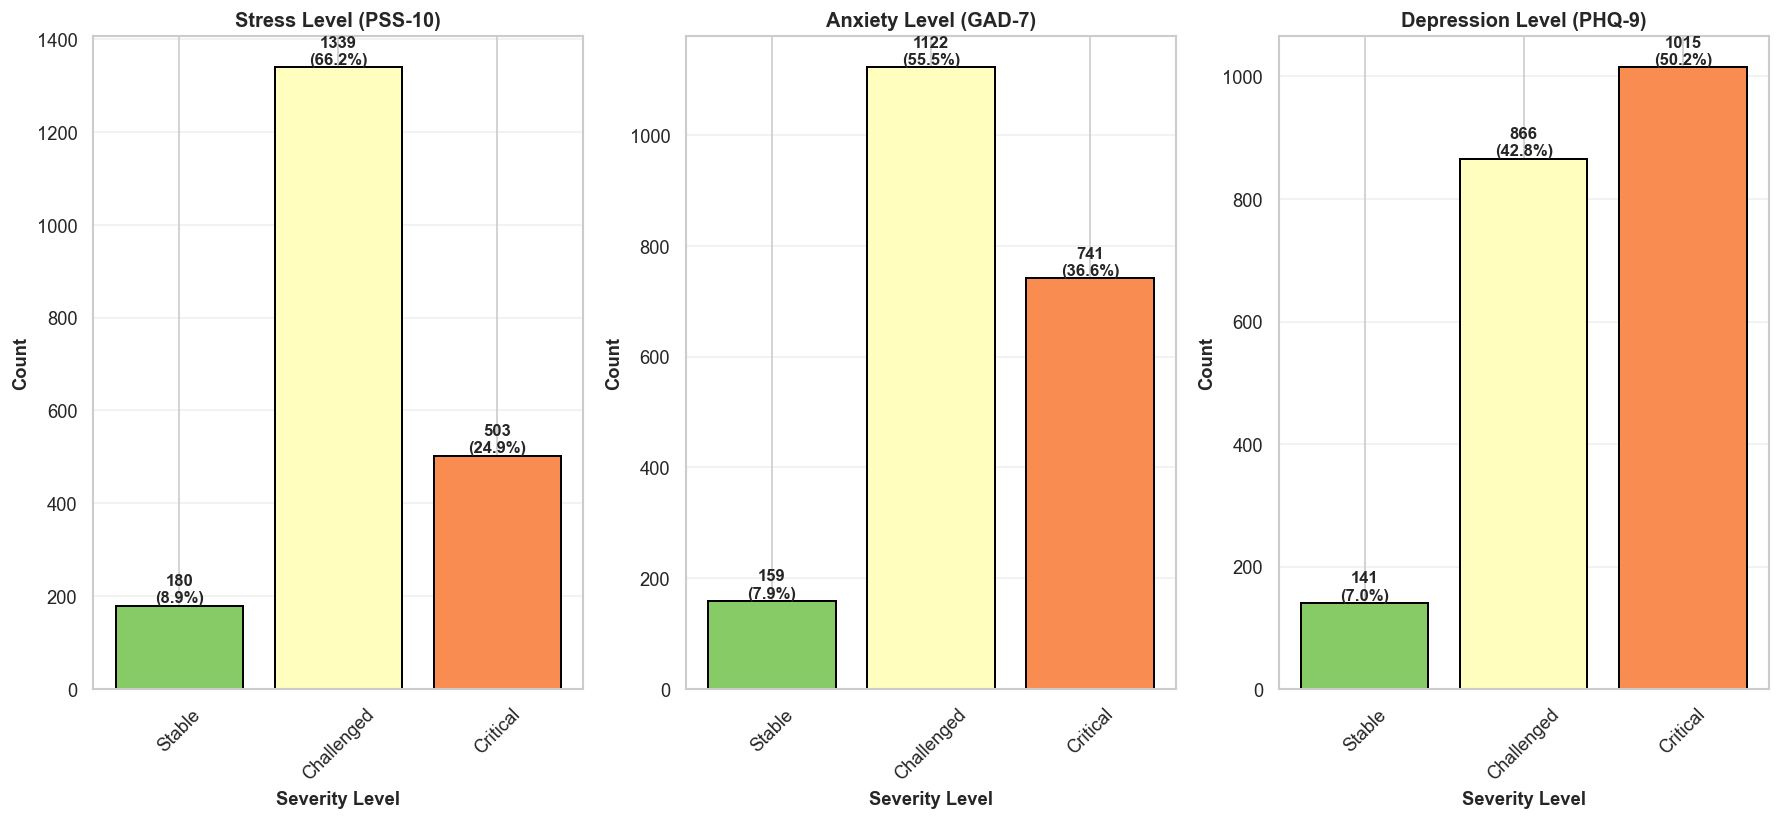


✅ Individual severity levels chart created

VISUALIZATION 3: CORRELATION AMONG RAW SCORES
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\03_correlation_raw_scores.png


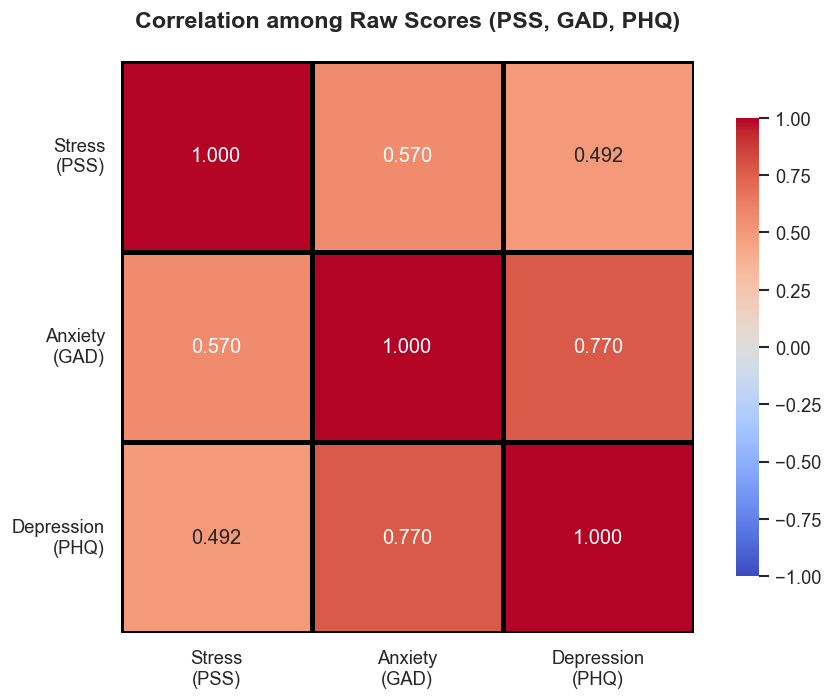


✅ Raw scores correlation heatmap created

Correlation coefficients:
               PSS Raw Score  GAD Raw Score  PHQ Raw Score
PSS Raw Score       1.000000       0.570163       0.492411
GAD Raw Score       0.570163       1.000000       0.769748
PHQ Raw Score       0.492411       0.769748       1.000000

VISUALIZATION 4: COMBINED CORRELATION HEATMAP (ALL 26 ITEMS)
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\04_correlation_all_items_combined.png


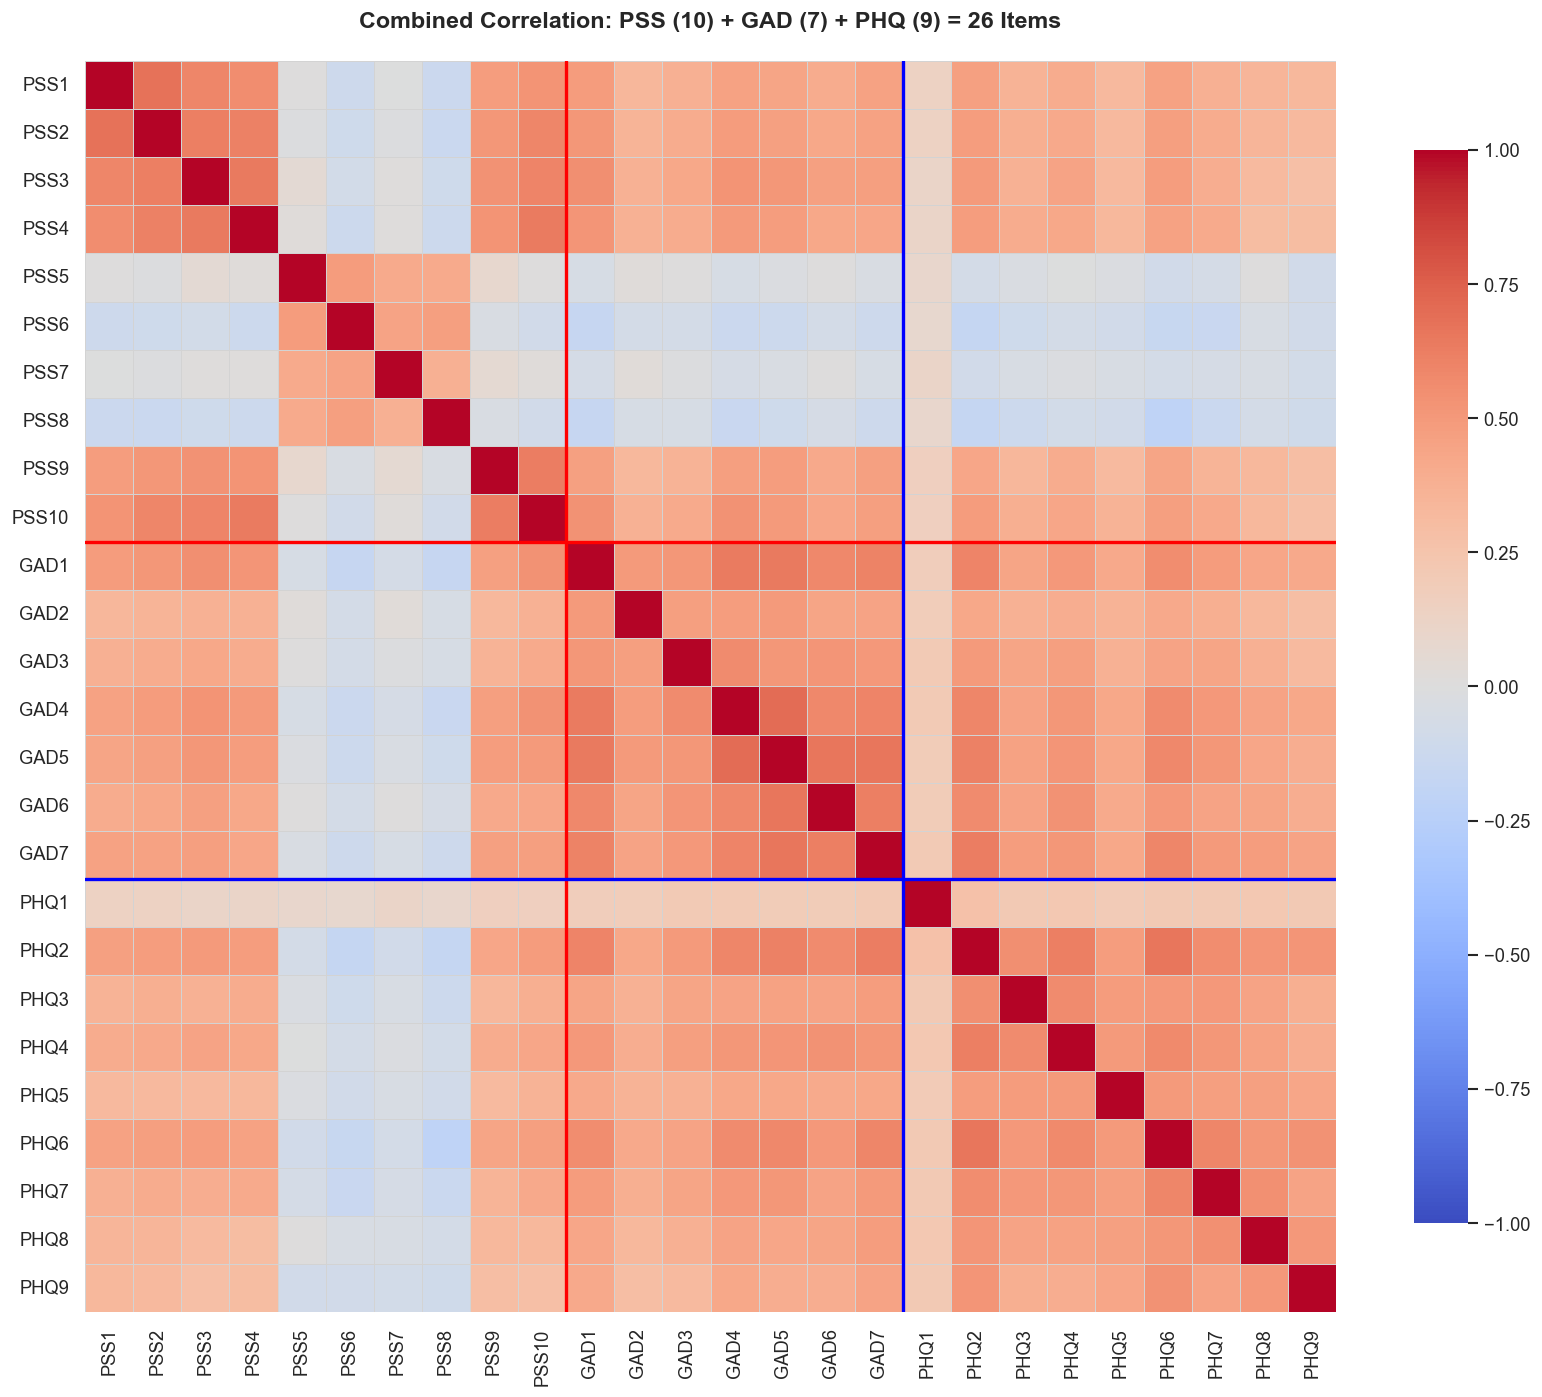


✅ Combined correlation heatmap created (26 items)

VISUALIZATION 5: PSS (STRESS) RESPONSE DISTRIBUTION
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\05_responses_pss_stress.png


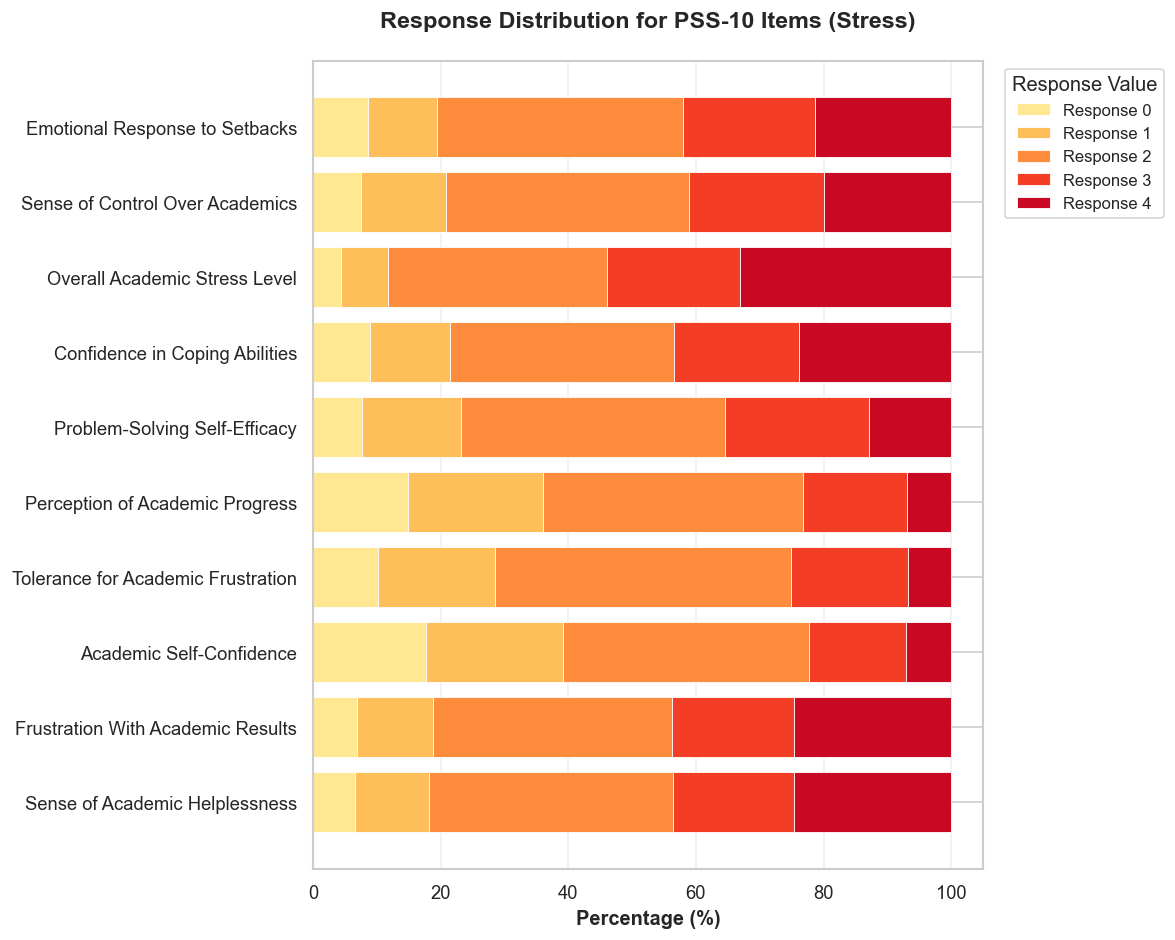


✅ PSS response distribution chart created

VISUALIZATION 6: GAD (ANXIETY) RESPONSE DISTRIBUTION
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\06_responses_gad_anxiety.png


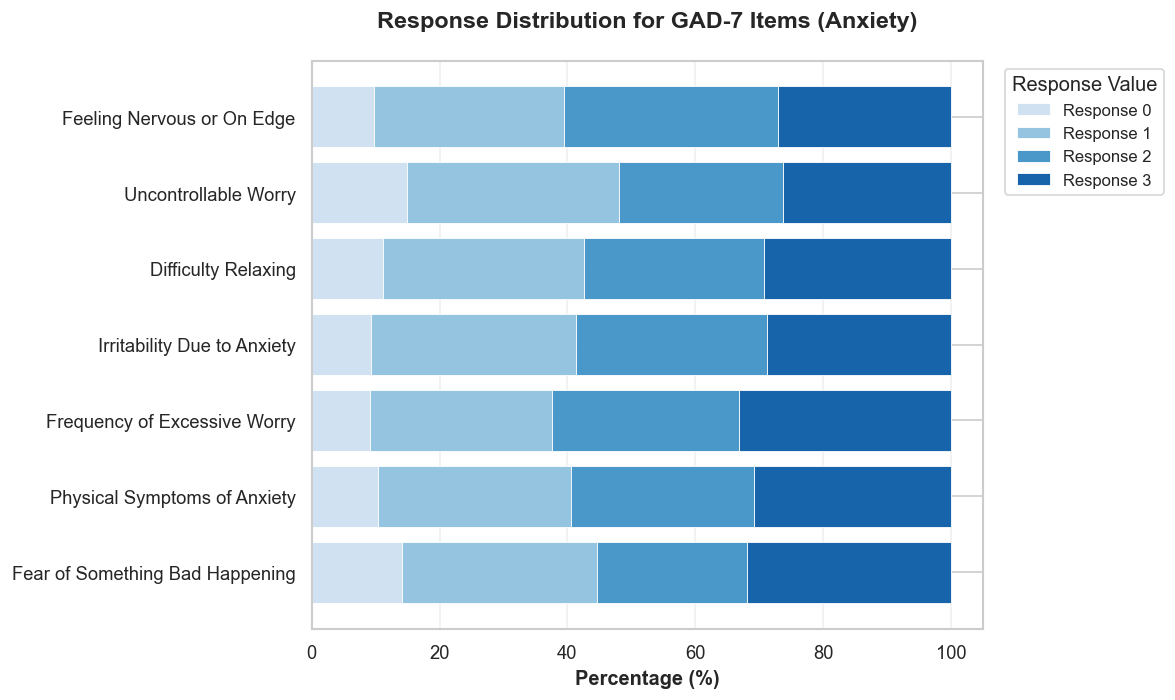


✅ GAD response distribution chart created

VISUALIZATION 7: PHQ (DEPRESSION) RESPONSE DISTRIBUTION
✅ Figure saved: D:\Programming\Projects\Baymax\figures\Exploratory Data Analysis\07_responses_phq_depression.png


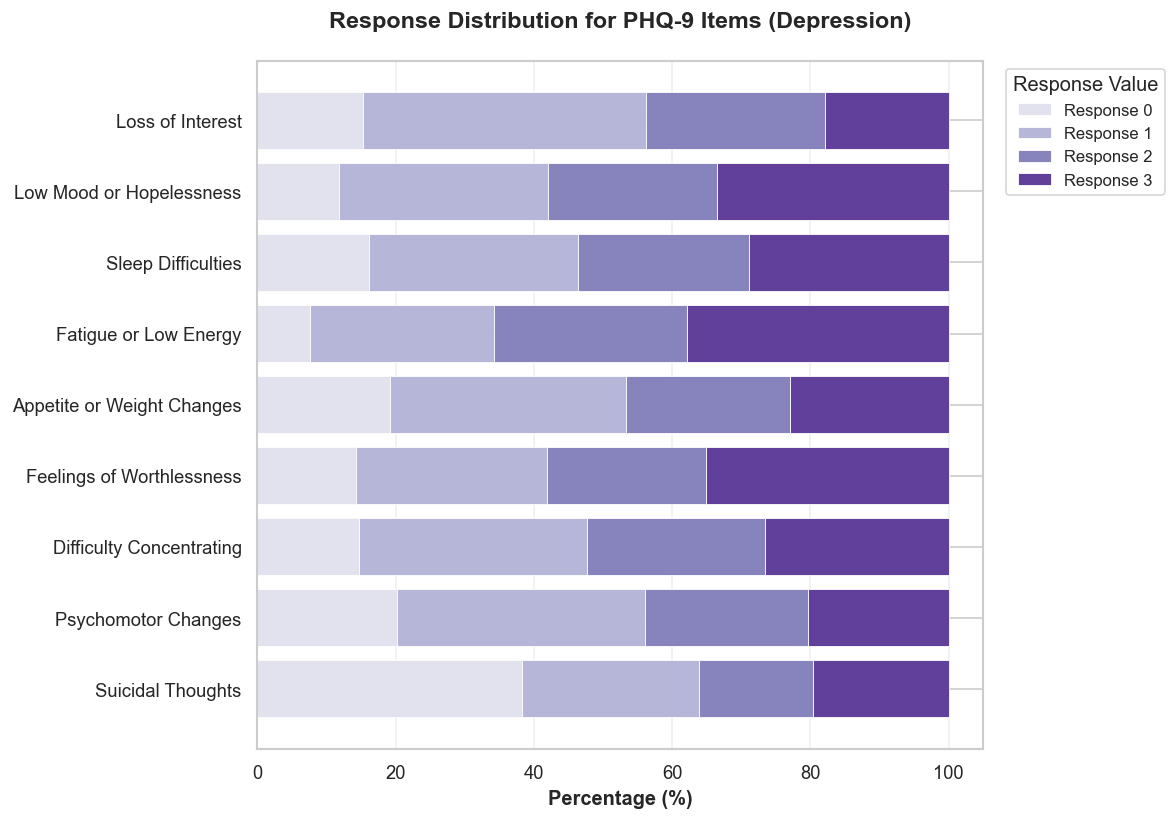


✅ PHQ response distribution chart created


In [3]:
# ============================================================================
# LOAD PROCESSED DATASET
# ============================================================================

print("=" * 80)
print("PART 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

df = pd.read_csv(PROCESSED_TABULAR)
print(f"\n💾 Loaded processed dataset from: {PROCESSED_TABULAR}")
print(f"Shape: {df.shape}")

# Detect scale columns
pss_cols = [c for c in df.columns if c.upper().startswith("PSS") and c not in ["PSS Raw Score"]]
gad_cols = [c for c in df.columns if c.upper().startswith("GAD") and c not in ["GAD Raw Score"]]
phq_cols = [c for c in df.columns if c.upper().startswith("PHQ") and c not in ["PHQ Raw Score"]]

print(f"\n✅ Detected scale columns:")
print(f"   PSS (Stress):    {len(pss_cols)} items")
print(f"   GAD (Anxiety):   {len(gad_cols)} items")
print(f"   PHQ (Depression): {len(phq_cols)} items")
print(f"   Total:           {len(pss_cols) + len(gad_cols) + len(phq_cols)} items")

FIG_DIR.mkdir(parents=True, exist_ok=True)
print(f"\n💾 Figures will be saved to: {FIG_DIR}")

# ============================================================================
# VISUALIZATION 1: MENTAL HEALTH STATUS DISTRIBUTION
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 1: MENTAL HEALTH STATUS DISTRIBUTION")
print("=" * 80)

mhs_counts = df["Mental Health Status"].value_counts().reindex(MENTAL_HEALTH_LEVELS)

fig, ax = plt.subplots(figsize=(10, 8))
colors_mhs = sns.color_palette("RdYlGn_r", len(MENTAL_HEALTH_LEVELS))

bars = ax.bar(mhs_counts.index, mhs_counts.values, color=colors_mhs,
              edgecolor="black", linewidth=1.2)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{int(height)}\n({height / len(df) * 100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel("Mental Health Status", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.set_title("Distribution of Mental Health Status", fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
save_fig(fig, "01_mental_health_status_distribution", FIG_DIR)
plt.show()

print("\n✅ Mental Health Status distribution chart created")
print(f"   Distribution: {mhs_counts.to_dict()}")

# ============================================================================
# VISUALIZATION 2: INDIVIDUAL SEVERITY LEVELS DISTRIBUTION
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 2: INDIVIDUAL SEVERITY LEVELS DISTRIBUTION")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
severity_columns = ["Stress Level", "Anxiety Level", "Depression Level"]
titles = ["Stress Level (PSS-10)", "Anxiety Level (GAD-7)", "Depression Level (PHQ-9)"]
colors_severity = sns.color_palette("RdYlGn_r", len(SEVERITY_LEVELS))

for ax, col, title in zip(axes, severity_columns, titles):
    counts = df[col].value_counts().reindex(SEVERITY_LEVELS)
    bars = ax.bar(counts.index, counts.values, color=colors_severity,
                  edgecolor="black", linewidth=1.2)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}\n({height / len(df) * 100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel("Severity Level", fontsize=11, fontweight='bold')
    ax.set_ylabel("Count", fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
save_fig(fig, "02_individual_severity_levels", FIG_DIR)
plt.show()

print("\n✅ Individual severity levels chart created")

# ============================================================================
# VISUALIZATION 3: CORRELATION AMONG RAW SCORES
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 3: CORRELATION AMONG RAW SCORES")
print("=" * 80)

raw_score_cols = ["PSS Raw Score", "GAD Raw Score", "PHQ Raw Score"]
raw_corr = df[raw_score_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(raw_corr, annot=True, fmt=".3f", cmap="coolwarm",
            vmin=-1, vmax=1, ax=ax, square=True,
            cbar_kws={"shrink": 0.8}, linewidths=2, linecolor='black')

ax.set_title("Correlation among Raw Scores (PSS, GAD, PHQ)", fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(["Stress\n(PSS)", "Anxiety\n(GAD)", "Depression\n(PHQ)"], fontsize=11)
ax.set_yticklabels(["Stress\n(PSS)", "Anxiety\n(GAD)", "Depression\n(PHQ)"], fontsize=11, rotation=0)
plt.tight_layout()
save_fig(fig, "03_correlation_raw_scores", FIG_DIR)
plt.show()

print("\n✅ Raw scores correlation heatmap created")
print("\nCorrelation coefficients:")
print(raw_corr)

# ============================================================================
# VISUALIZATION 4: COMBINED CORRELATION HEATMAP (ALL 26 ITEMS)
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 4: COMBINED CORRELATION HEATMAP (ALL 26 ITEMS)")
print("=" * 80)

all_items = pss_cols + gad_cols + phq_cols
corr_all  = df[all_items].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_all, cmap="coolwarm", vmin=-1, vmax=1, ax=ax,
            square=True, cbar_kws={"shrink": 0.8},
            linewidths=0.5, linecolor='lightgray')

ax.set_title("Combined Correlation: PSS (10) + GAD (7) + PHQ (9) = 26 Items",
             fontsize=14, fontweight='bold', pad=20)

# Section dividers
ax.axhline(y=len(pss_cols),              color='red',  linewidth=2)
ax.axvline(x=len(pss_cols),              color='red',  linewidth=2)
ax.axhline(y=len(pss_cols) + len(gad_cols), color='blue', linewidth=2)
ax.axvline(x=len(pss_cols) + len(gad_cols), color='blue', linewidth=2)

plt.tight_layout()
save_fig(fig, "04_correlation_all_items_combined", FIG_DIR)
plt.show()

print("\n✅ Combined correlation heatmap created (26 items)")

# ============================================================================
# VISUALIZATION 5: PSS RESPONSE DISTRIBUTION
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 5: PSS (STRESS) RESPONSE DISTRIBUTION")
print("=" * 80)

pss_pct = (df[pss_cols].apply(lambda col: col.value_counts(normalize=True).sort_index()) * 100).fillna(0)

for val in [0, 1, 2, 3, 4]:
    if val not in pss_pct.index:
        pss_pct.loc[val] = 0
pss_pct = pss_pct.sort_index()

pss_pct_t = pss_pct.T[sorted(pss_pct.index)].reindex(pss_cols)
pss_pct_t.index = [PSS_LABELS[col] for col in pss_cols]

fig, ax = plt.subplots(figsize=(10, 8))
colors_pss = sns.color_palette("YlOrRd", len(pss_pct_t.columns))
bottom = np.zeros(len(pss_pct_t))

for i, col in enumerate(pss_pct_t.columns):
    vals = pss_pct_t[col].values
    ax.barh(pss_pct_t.index, vals, left=bottom, color=colors_pss[i],
            edgecolor='white', linewidth=0.5, label=f"Response {int(col)}")
    bottom += vals

ax.set_xlabel("Percentage (%)", fontsize=12, fontweight='bold')
ax.set_title("Response Distribution for PSS-10 Items (Stress)", fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.legend(title="Response Value", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_fig(fig, "05_responses_pss_stress", FIG_DIR)
plt.show()

print("\n✅ PSS response distribution chart created")

# ============================================================================
# VISUALIZATION 6: GAD RESPONSE DISTRIBUTION
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 6: GAD (ANXIETY) RESPONSE DISTRIBUTION")
print("=" * 80)

gad_pct = (df[gad_cols].apply(lambda col: col.value_counts(normalize=True).sort_index()) * 100).fillna(0)

for val in [0, 1, 2, 3]:
    if val not in gad_pct.index:
        gad_pct.loc[val] = 0
gad_pct = gad_pct.sort_index()

gad_pct_t = gad_pct.T[sorted(gad_pct.index)].reindex(gad_cols)
gad_pct_t.index = [GAD_LABELS[col] for col in gad_cols]

fig, ax = plt.subplots(figsize=(10, 6))
colors_gad = sns.color_palette("Blues", len(gad_pct_t.columns))
bottom = np.zeros(len(gad_pct_t))

for i, col in enumerate(gad_pct_t.columns):
    vals = gad_pct_t[col].values
    ax.barh(gad_pct_t.index, vals, left=bottom, color=colors_gad[i],
            edgecolor='white', linewidth=0.5, label=f"Response {int(col)}")
    bottom += vals

ax.set_xlabel("Percentage (%)", fontsize=12, fontweight='bold')
ax.set_title("Response Distribution for GAD-7 Items (Anxiety)", fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.legend(title="Response Value", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_fig(fig, "06_responses_gad_anxiety", FIG_DIR)
plt.show()

print("\n✅ GAD response distribution chart created")

# ============================================================================
# VISUALIZATION 7: PHQ RESPONSE DISTRIBUTION
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZATION 7: PHQ (DEPRESSION) RESPONSE DISTRIBUTION")
print("=" * 80)

phq_pct   = df[phq_cols].apply(pd.Series.value_counts, normalize=True).fillna(0) * 100
phq_pct_t = phq_pct.T.rename(index=PHQ_LABELS)

fig, ax = plt.subplots(figsize=(10, 7))
colors_phq = sns.color_palette("Purples", len(phq_pct_t.columns))
bottom = np.zeros(len(phq_pct_t))

for i, col in enumerate(sorted(phq_pct_t.columns)):
    vals = phq_pct_t[col].values
    ax.barh(phq_pct_t.index, vals, left=bottom, color=colors_phq[i],
            edgecolor='white', linewidth=0.5, label=f"Response {int(col)}")
    bottom += vals

ax.set_xlabel("Percentage (%)", fontsize=12, fontweight='bold')
ax.set_title("Response Distribution for PHQ-9 Items (Depression)", fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.legend(title="Response Value", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_fig(fig, "07_responses_phq_depression", FIG_DIR)
plt.show()

print("\n✅ PHQ response distribution chart created")

## Part 4: Feature Engineering

This cell prepares the final feature set for machine learning by encoding the target variable, scaling the features, and creating stratified train/test splits.

### What this cell does:

**1. Load Processed Dataset**
- Loads the cleaned dataset from Part 2
- Automatically detects all scale columns (PSS, GAD, PHQ)

**2. Create Encoded Target Variable**
- Converts Mental Health Status to numeric encoding:
  - `0` = Stable
  - `1` = Challenged
  - `2` = Critical
- Ensures proper stratification for train/test splits

**3. Feature Scaling**
- Applies `StandardScaler` (mean = 0, std = 1) to all features
- Fitted on training data only to prevent data leakage

**4. Train/Test Split**
- Stratified 80/20 split preserving class distribution
- `random_state = 42` for reproducibility

**5. Save Feature Set**
- `train.csv`: Training data (features + encoded target)
- `test.csv`: Test data (features + encoded target)
- `scaler.pkl`: Fitted StandardScaler object
- All saved to `features/`

In [4]:
# ============================================================================
# LOAD PROCESSED DATASET
# ============================================================================

print("=" * 80)
print("PART 4: FEATURE ENGINEERING")
print("=" * 80)

df = pd.read_csv(PROCESSED_TABULAR)
print(f"\n💾 Loaded processed dataset from: {PROCESSED_TABULAR}")
print(f"Shape: {df.shape}")

# Detect scale columns
pss_cols = [c for c in df.columns if c.upper().startswith("PSS") and c not in ["PSS Raw Score"]]
gad_cols = [c for c in df.columns if c.upper().startswith("GAD") and c not in ["GAD Raw Score"]]
phq_cols = [c for c in df.columns if c.upper().startswith("PHQ") and c not in ["PHQ Raw Score"]]

# Combine all scale items
all_features = pss_cols + gad_cols + phq_cols

print(f"\n✅ Detected scale items:")
print(f"   PSS (Stress):     {len(pss_cols)} items — {pss_cols}")
print(f"   GAD (Anxiety):    {len(gad_cols)} items — {gad_cols}")
print(f"   PHQ (Depression): {len(phq_cols)} items — {phq_cols}")
print(f"   Total features:   {len(all_features)}")

# ============================================================================
# CREATE ENCODED TARGET VARIABLE
# ============================================================================

print("\n" + "=" * 80)
print("CREATING ENCODED TARGET VARIABLE")
print("=" * 80)

status_mapping = {"Stable": 0, "Challenged": 1, "Critical": 2}
df["Mental Health Status Encoded"] = df["Mental Health Status"].map(status_mapping)

print("✅ Mental Health Status Encoded created")
print("\nTarget distribution (Mental Health Status Encoded):")
print(df["Mental Health Status Encoded"].value_counts().sort_index())
print("\nMapping:")
print("   0 = Stable")
print("   1 = Challenged")
print("   2 = Critical")

# ============================================================================
# TRAIN/TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

X = df[all_features].copy()
y = df["Mental Health Status Encoded"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\n✅ Stratified 80/20 split applied")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set:     {X_test.shape[0]} samples")

# ============================================================================
# FEATURE SCALING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)

# Fit scaler on training data only to prevent data leakage
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=all_features,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=all_features,
    index=X_test.index
)

print(f"\n✅ StandardScaler applied (fit on training data only)")
print(f"   Training set shape: {X_train_scaled.shape}")
print(f"   Test set shape:     {X_test_scaled.shape}")

# ============================================================================
# SAVE FEATURE SET
# ============================================================================

print("\n" + "=" * 80)
print("SAVING FEATURE SET")
print("=" * 80)

# Prepare train dataframe
train_df = X_train_scaled.copy()
train_df["Mental Health Status Encoded"] = y_train.values

# Prepare test dataframe
test_df = X_test_scaled.copy()
test_df["Mental Health Status Encoded"] = y_test.values

# Create output directory and save
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

train_df.to_csv(FEATURES_DIR / "train.csv", index=False)
test_df.to_csv(FEATURES_DIR  / "test.csv",  index=False)
joblib.dump(scaler, FEATURES_DIR / "scaler.pkl")

print(f"\n✅ Feature set saved successfully:")
print(f"   train.csv  → {train_df.shape}")
print(f"   test.csv   → {test_df.shape}")
print(f"   scaler.pkl → StandardScaler fitted on {X_train_scaled.shape[0]} samples")
print(f"\n   Saved to: {FEATURES_DIR.resolve()}")

# ============================================================================
# VERIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("VERIFICATION")
print("=" * 80)

train_verify = pd.read_csv(FEATURES_DIR / "train.csv")
test_verify  = pd.read_csv(FEATURES_DIR  / "test.csv")

print(f"\n✅ Train set verification:")
print(f"   Shape:          {train_verify.shape}")
print(f"   Missing values: {train_verify.isna().sum().sum()}")
print(f"\n   Target distribution:")
for label, name in zip([0, 1, 2], ["Stable", "Challenged", "Critical"]):
    count = (train_verify["Mental Health Status Encoded"] == label).sum()
    pct   = count / len(train_verify) * 100
    print(f"     {label} ({name:10s}): {count:4d}  ({pct:.2f}%)")

print(f"\n✅ Test set verification:")
print(f"   Shape:          {test_verify.shape}")
print(f"   Missing values: {test_verify.isna().sum().sum()}")
print(f"\n   Target distribution:")
for label, name in zip([0, 1, 2], ["Stable", "Challenged", "Critical"]):
    count = (test_verify["Mental Health Status Encoded"] == label).sum()
    pct   = count / len(test_verify) * 100
    print(f"     {label} ({name:10s}): {count:4d}  ({pct:.2f}%)")

print(f"\n✅ Feature Engineering Complete")

PART 4: FEATURE ENGINEERING

💾 Loaded processed dataset from: d:\Programming\Projects\Baymax\data\processed\mhp_processed.csv
Shape: (2022, 40)

✅ Detected scale items:
   PSS (Stress):     10 items — ['PSS1', 'PSS2', 'PSS3', 'PSS4', 'PSS5', 'PSS6', 'PSS7', 'PSS8', 'PSS9', 'PSS10']
   GAD (Anxiety):    7 items — ['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']
   PHQ (Depression): 9 items — ['PHQ1', 'PHQ2', 'PHQ3', 'PHQ4', 'PHQ5', 'PHQ6', 'PHQ7', 'PHQ8', 'PHQ9']
   Total features:   26

CREATING ENCODED TARGET VARIABLE
✅ Mental Health Status Encoded created

Target distribution (Mental Health Status Encoded):
Mental Health Status Encoded
0     126
1    1111
2     785
Name: count, dtype: int64

Mapping:
   0 = Stable
   1 = Challenged
   2 = Critical

TRAIN/TEST SPLIT

✅ Stratified 80/20 split applied
   Training set: 1617 samples
   Test set:     405 samples

FEATURE SCALING

✅ StandardScaler applied (fit on training data only)
   Training set shape: (1617, 26)
   Test set shap